In [1]:
#bibliotecas necesarias para el funcionamiento
import pandas                  as pd                     #manejo y manipulación de dataframes
import scipy
import numpy                   as np                     #soporte matricial y vectorial
import matplotlib.pyplot       as plt                    #graficos
import joblib
from   sklearn.model_selection import GridSearchCV       #optimización de hiperparametros
from   sklearn                 import metrics            #metricas de validación
from   sklearn.model_selection import train_test_split   #segmentación de muestra
from   sklearn.linear_model    import LogisticRegression #clasificador 
from   sklearn.impute          import SimpleImputer      
from   sklearn.compose         import ColumnTransformer
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import LabelEncoder
from   sklearn.preprocessing   import OneHotEncoder,StandardScaler
from   sklearn.preprocessing   import KBinsDiscretizer
from   sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score

In [2]:
!pip install joblib

In [3]:
#columnas con las covariables que se van a seleccionar del modelo
columnas=["SEXO","OBESIDAD","DIABETES","EPOC","ASMA","CARDIOVASCULAR","RENAL CRONICA","INMUNOSUPRESION","HIPERTENSION","TABAQUISMO","TIPO PACIENTE","EDAD"]

In [4]:
#Nos quedamos unicamente con los positivos
filelocal="dataCovid/casos-asociados-a-covid-1920jul.csv"
def getData(file,columnas,filtro="positivo"):
    df=pd.read_csv(file,header=0,sep=",",encoding='utf-8',low_memory=False)
    df=df.query(filtro+"=='Positivo SARS-CoV-2'")
    df=df.loc[:,columnas]
    print("casos totales")
    print(df.shape)
    return df  

In [5]:
#quitamos aquellos datos donde se ingora la condicion
def limpiaData(data,feature,conditions):
    df=data
    for i in feature:
        df = df.drop(df[(df[i] == conditions)].index)
    print("datos finales "+str(df.shape))    
    return df

In [6]:
df=getData(filelocal,columnas) 
feat=['OBESIDAD','DIABETES','EPOC','ASMA',"CARDIOVASCULAR",'RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION","TABAQUISMO"]
df=limpiaData(df,feat,'SE IGNORA')

casos totales
(349396, 12)
datos finales (347353, 12)


In [7]:
df=df.query("EDAD<100")

In [11]:
df.to_csv("covidfilter.csv")

In [21]:
#proporción de pacientes ambulatorios y hospitalizados
df["TIPO PACIENTE"].value_counts()

AMBULATORIO      248931
HOSPITALIZADO     98365
Name: TIPO PACIENTE, dtype: int64

In [22]:
y=LabelEncoder().fit_transform(df["TIPO PACIENTE"])
X=df.drop(["TIPO PACIENTE"],axis=1)
X.head(1)

,SEXO,OBESIDAD,DIABETES,EPOC,ASMA,CARDIOVASCULAR,RENAL CRONICA,INMUNOSUPRESION,HIPERTENSION,TABAQUISMO,EDAD
0,MUJER,NO,NO,NO,NO,NO,NO,NO,NO,NO,51


In [23]:
#crea un pipeline para generar el modelo
def modelo(X_train, y_train,numeric_features,categorical_features):
    numeric_transformer = Pipeline(steps=[
    ('imputer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))])
    categorical_transformer = Pipeline(steps=[
        #imputacion por el valor más frecuente
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    #onehot encoder para las varibales categoricas    
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    #el pipeline con el procesamienot y el claificador
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', gridsearh())])
    modelo=clf.fit(X_train, y_train)
    return modelo

#### Hiperparámetro
Un hiperparámetro de un modelo es una caracateristica que es externa al modelo y cuyo valor no se puede estimar a partir de los datos. El valor del hiperparámetro debe establecerse al inicio del proceso de aprendizaje.
Ejemplo:
1. penality: l1 o l2 se usa para especificar la norma usada en la penalización.
2. C: Inverso de la intensidad de la regularización: los valores más pequeños de C especifican una regularización más fuerte.


In [34]:
#El grid search prueba con varios modelos usando holdout 70-30
def gridsearh():
    clf = LogisticRegression(fit_intercept=True,solver='lbfgs',tol=1e-5,max_iter=75,n_jobs=8)
    grid_values = {'penalty': [ 'l2'],'C':np.logspace(-5, 5, 100)}
    """se evalúan todas las combinaciones posibles de valores de parámetros y 
    se conserva la mejor combinacion."""   
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy')
    return grid_clf_acc

In [35]:
#El score obtenido con el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
categorical_features = ['SEXO','OBESIDAD','DIABETES','EPOC','ASMA','CARDIOVASCULAR','RENAL CRONICA',"INMUNOSUPRESION","HIPERTENSION"]
numeric_features=['EDAD']
modelo=modelo(X_train, y_train,numeric_features,categorical_features)
print("model score: %.3f" % modelo.score(X_test, y_test))

model score: 0.764


In [12]:
#se guarda el modelo serializado
joblib.dump(modelo,"modelos/logistic_modelV3.pkl")

['modelos/logistic_modelV3.pkl']

In [14]:
#Se imprimen los coeficientes asociados a los estimadores
print(modelo.named_steps['classifier'].best_estimator_.coef_)
print(modelo.named_steps['classifier'].best_estimator_.intercept_)

[[ 0.60223161  0.24604172 -0.24458869 -0.11828154  0.11973457 -0.3105908
   0.31204383 -0.20852159  0.20997462  0.07673378 -0.07528074 -0.09529004
   0.09674308 -0.47427283  0.47572587 -0.38590464  0.38735768 -0.13907668
   0.14052971]]
[-0.97890178]


In [15]:
print(modelo.named_steps['classifier'].best_estimator_)

LogisticRegression(C=0.010722672220103232, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=75, multi_class='auto', n_jobs=8, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)


In [16]:
#la matriz de confusion
predict=modelo.predict(X_test)
cm = metrics.confusion_matrix(y_test, predict)
print(cm) 

[[66503  8162]
 [16612 12957]]


array([[0.80013235, 0.38647663],
       [0.19986765, 0.61352337]])

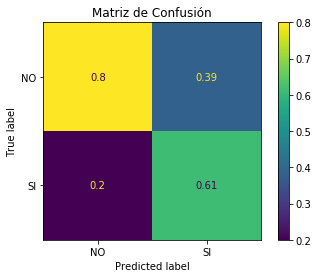

In [17]:
#la matriz de confusion en scikit learn noraalizado
disp=metrics.plot_confusion_matrix(modelo, X_test, y_test,normalize="pred",display_labels=np.array(["NO","SI"]))
disp.ax_.set_title("Matriz de Confusión")
disp.confusion_matrix

### Métricas
1. Accuracy o exactitud: es el número de predicciones correctas contra el número total de predicciones, 
$$
  Accuracy= \dfrac{TP+TN}{TP+FP+TN+FN}
$$
2. Precisión: Es el ratio entre positivos "verdaderos" y todos los positivos(que se clasificaron como tal aunque realmente no lo son),
$$
  Precision= \dfrac{TP}{TP+FP}
$$

3. Recall(sensibilidad) Es el ratio de positivos "verdaderos" (aquellos clasificadas como positivos, que son realmente lo son) entre todos los positivos (TP y FN)
$$
  Recall= \dfrac{TP}{TP+FN}
$$

In [19]:
#calculo de las probabilidades y el AUC
probs = modelo.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

In [37]:
predictions=modelo.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.7623232342613735
Precision score:  0.6135233675836924
Recall score:  0.4381954073522946
F1 score:  0.5112452651515151


(array([25651.,  3620., 16608., 10134.,  7133.,  2646., 10019.,  3503.,
         2997.,  7475.,  4638.,  2109.,  3034.,  2348.,   962.,   646.,
          499.,   175.,    37.]),
 array([0.04605765, 0.09471475, 0.14337185, 0.19202896, 0.24068606,
        0.28934316, 0.33800026, 0.38665736, 0.43531446, 0.48397157,
        0.53262867, 0.58128577, 0.62994287, 0.67859997, 0.72725707,
        0.77591418, 0.82457128, 0.87322838, 0.92188548, 0.97054258]),
 <a list of 19 Patch objects>)

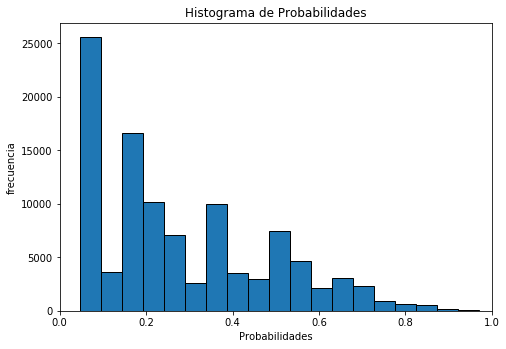

In [20]:
fig=plt.figure()
axes=fig.add_axes([1,1,1.0,1.0])
axes.set_title("Histograma de Probabilidades")
axes.set_xlim(0,1)
axes.set_xlabel("Probabilidades")
axes.set_ylabel("frecuencia")
axes.hist(preds,bins=19,edgecolor="black")

(0, 1)

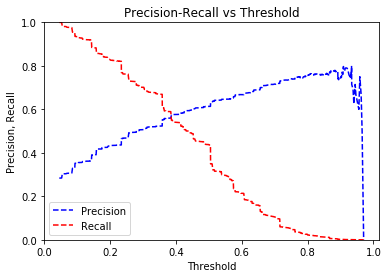

In [21]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs[:,1]) 
pr_auc = metrics.auc(recall, precision)
plt.title("Precision-Recall vs Threshold")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

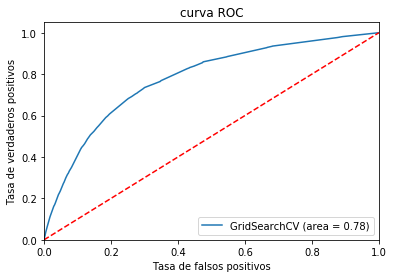

In [33]:
plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('curva ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()